In [108]:
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io
from scipy.fft import fft2, ifft2
from sklearn.metrics import mean_absolute_error as mae
import pywt

(2048, 2048)

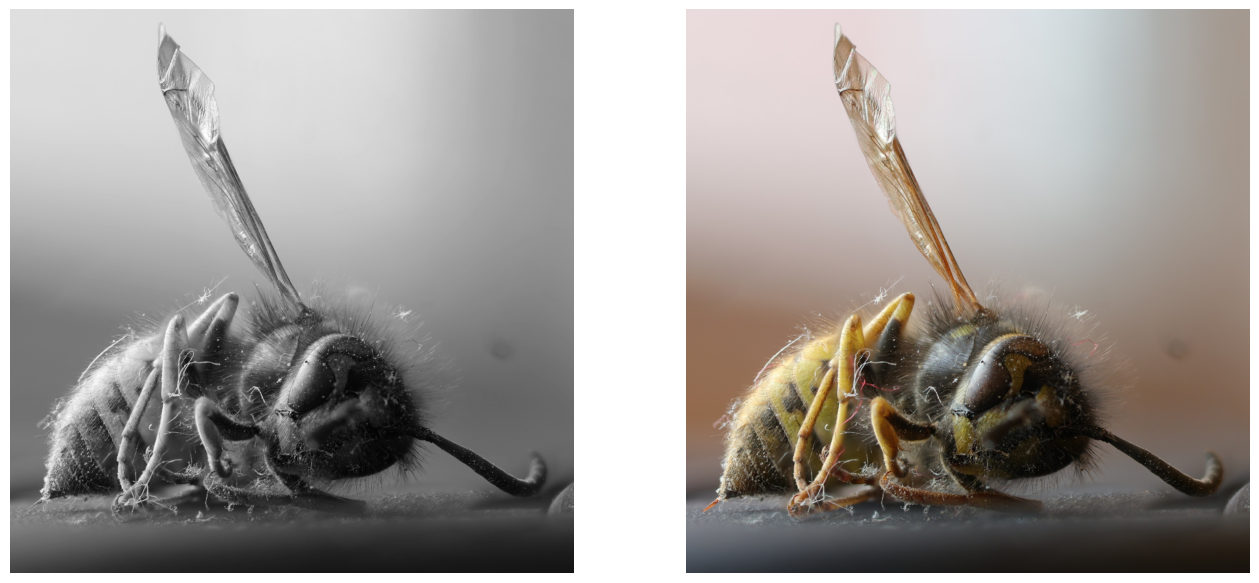

In [109]:
wasp_rgb = io.imread('wasp.png')
wasp_grayscale =  io.imread('wasp.png', as_gray=True)
#wasp_grayscale =  np.mean(wasp_rgb, -1)
plt.figure(figsize=(16, 16))

plt.subplot(1,2,1)
plt.imshow(wasp_grayscale, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wasp_rgb)
plt.axis('off')

wasp_grayscale.shape

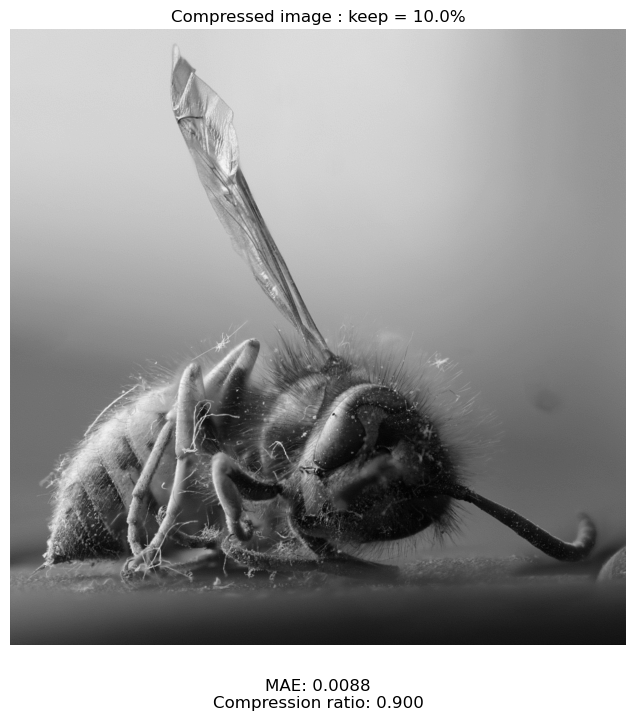

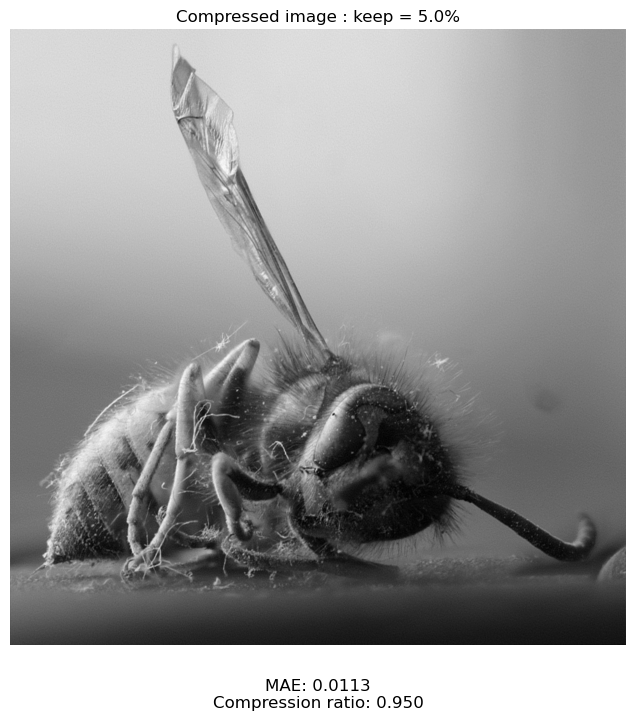

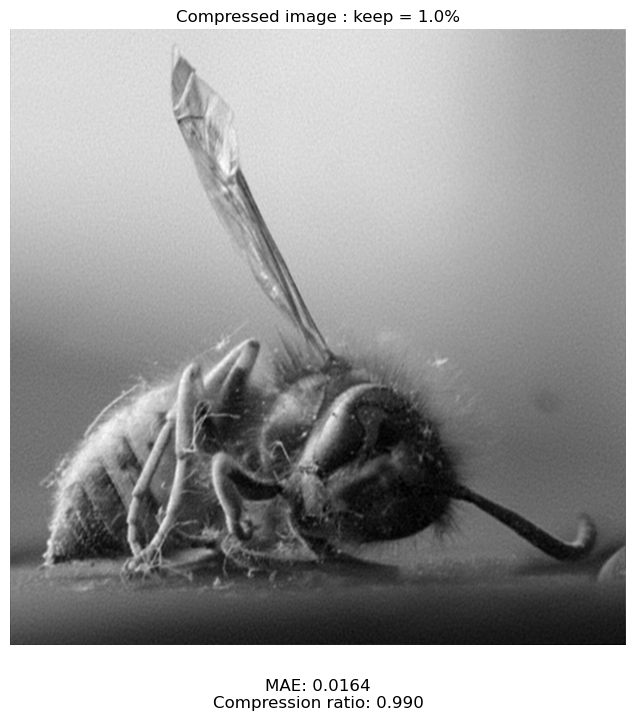

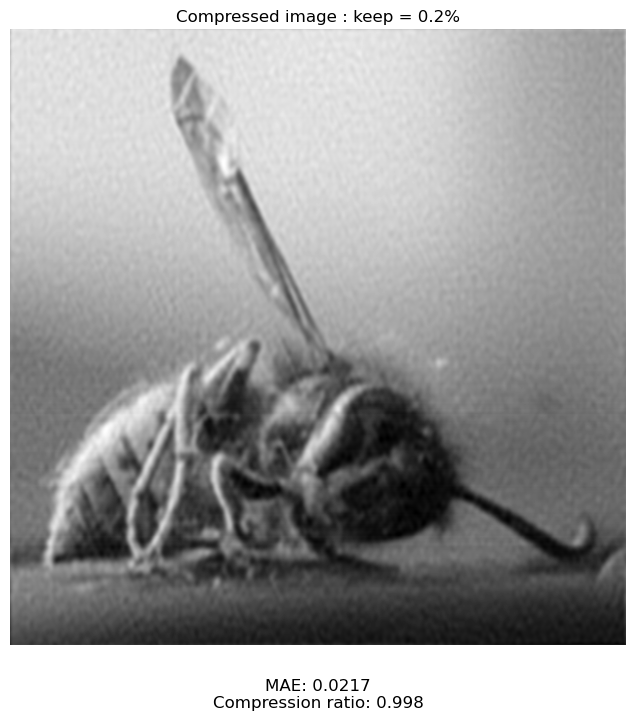

In [110]:
wasp_fft = fft2(wasp_grayscale)
wasp_fft_sorted = np.sort(np.abs(wasp_fft.flatten()))

for keep in (0.1, 0.05, 0.01, 0.002):
    
    thresh = wasp_fft_sorted[int((1-keep)*len(wasp_fft_sorted))]
    wasp_fft_thresh = wasp_fft * (np.abs(wasp_fft) > thresh)
    wasp_thresh = np.abs(ifft2(wasp_fft_thresh))
    
    plt.figure(figsize=(8, 8))
    plt.imshow(wasp_thresh, cmap='gray')
    plt.axis('off')
    mae_value = mae(wasp_grayscale, wasp_thresh)
    C = np.sum(np.abs(wasp_fft) <= thresh) / wasp_fft.size
    plt.title(f'Compressed image : keep = {keep*100}%')
    plt.text(0.5, -0.1, f"MAE: {mae_value:.4f}\nCompression ratio: {C:.3f}",fontsize=12, ha='center', transform=plt.gca().transAxes)
    


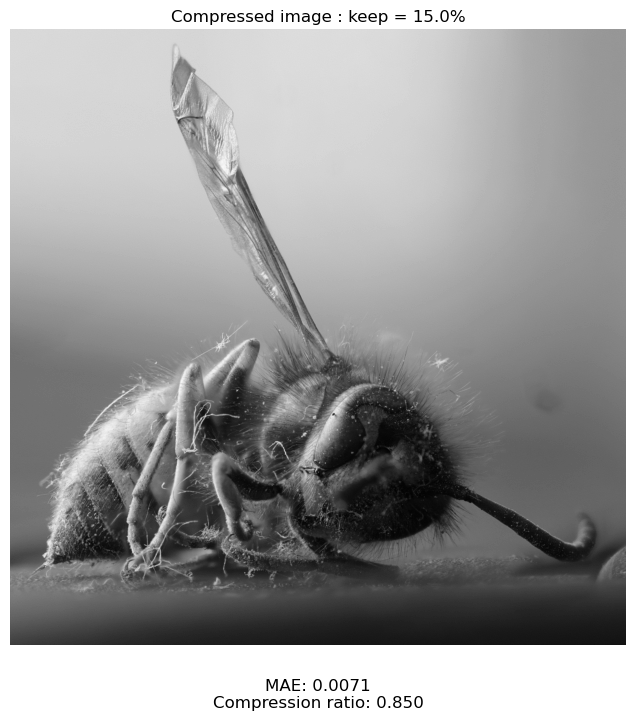

In [111]:

def compress_image_grayscale(image, keep):
   
    wasp_fft = fft2(image)
    wasp_fft_sorted = np.sort(np.abs(wasp_fft.flatten()))

    
    thresh = wasp_fft_sorted[int((1-keep)*len(wasp_fft_sorted))]
    wasp_fft_thresh = wasp_fft * (np.abs(wasp_fft) > thresh)
    wasp_thresh = np.abs(ifft2(wasp_fft_thresh))

    plt.figure(figsize=(8, 8))
    plt.imshow(wasp_thresh, cmap='gray')
    plt.axis('off')
    plt.title(f'Compressed image : keep = {keep*100}%')
    
    mae_value = mae(wasp_grayscale, wasp_thresh)
    C = np.sum(np.abs(wasp_fft) <= thresh) / wasp_fft.size
    plt.text(0.5, -0.1, f"MAE: {mae_value:.4f}\nCompression ratio: {C:.3f}", fontsize=12, ha='center', transform=plt.gca().transAxes)
        
        
compress_image_grayscale(wasp_grayscale, 0.15)

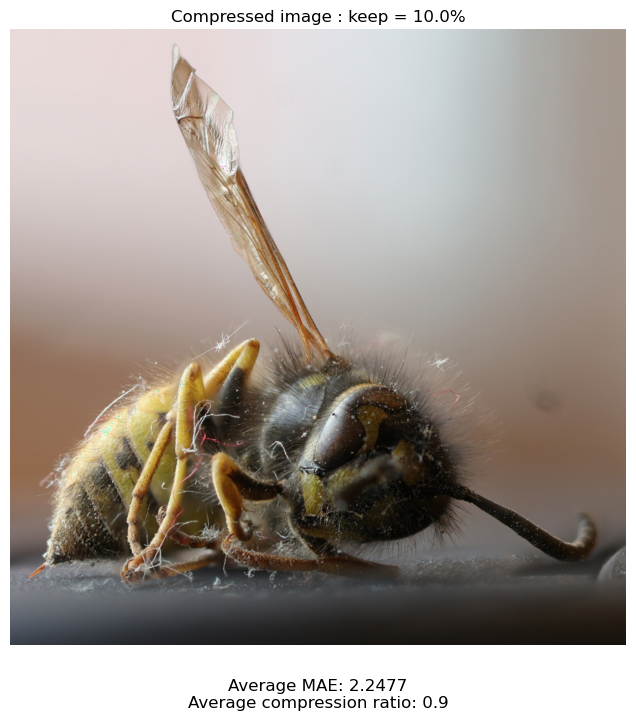

In [112]:

def compress_image_rgb(image, keep):
  
    compressed_channels = []
    mae_values = []
    C_values = []
    
    for channel in range(3):  
        channel_data = image[:, :, channel]
        channel_fft = fft2(channel_data)
        channel_fft_sorted = np.sort(np.abs(channel_fft.flatten()))

        thresh = channel_fft_sorted[int((1-keep)*len(channel_fft_sorted))]
        channel_fft_thresh = channel_fft * (np.abs(channel_fft) > thresh)
        channel_thresh = np.abs(ifft2(channel_fft_thresh))
        
        compressed_channels.append(channel_thresh)
        mae_values.append(mae(channel_data, channel_thresh))
        C_values.append(np.sum(np.abs(channel_fft) <= thresh) / channel_fft.size)
                        
    compressed_image = np.stack(compressed_channels, axis=-1)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(compressed_image.astype(np.uint8))
    plt.axis('off')
    plt.title(f'Compressed image : keep = {keep*100}%')
    
    average_mae = np.mean(mae_values)
    average_C = np.mean(C_values)
    plt.text(0.5, -0.1, f"Average MAE: {average_mae:.4f}\nAverage compression ratio: {average_C:.3}", fontsize=12, ha='center', transform=plt.gca().transAxes)
    
    
    
compress_image_rgb(wasp_rgb, 0.1)


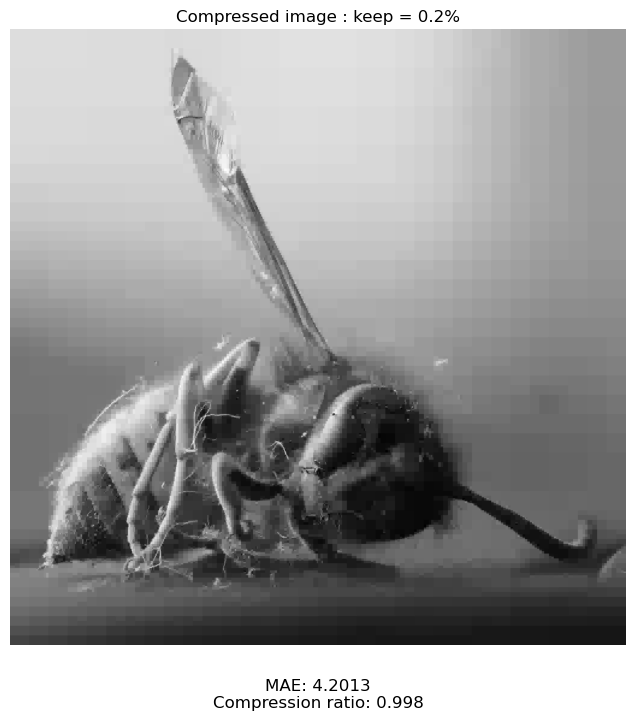

In [120]:

def wavelet_compression(image, keep, wavelet, level = 4):
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
        
    coeffs = pywt.wavedec2(image,wavelet,level)

    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

    coeff_sort = np.sort(np.abs(coeff_arr.flatten()))

    
    thresh = coeff_sort[int(np.floor((1-keep)*len(coeff_sort)))]
    ind = np.abs(coeff_arr) > thresh
    Cfilt = coeff_arr * ind 
        
    coeffs_filt = pywt.array_to_coeffs(Cfilt,coeff_slices,output_format='wavedec2')
    
    image_recon = pywt.waverec2(coeffs_filt,wavelet)
    image_recon = np.clip(image_recon, 0, 255)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image_recon.astype(np.uint8), cmap='gray')
    plt.axis('off')
    plt.title(f'Compressed image : keep = {keep*100}%')
    
    mae_value = mae(image, image_recon)
    C = np.sum(np.abs(coeff_arr) <= thresh) / coeff_arr.size
    plt.text(0.5, -0.1, f"MAE: {mae_value:.4f}\nCompression ratio: {C:.3f}", fontsize=12, ha='center', transform=plt.gca().transAxes)
    
wavelet_compression(wasp_grayscale, 0.002, wavelet='db1')
    